In [5]:
from __future__ import print_function
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adadelta, Adagrad, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.utils import to_categorical

from loading_data import load_mnist
from six.moves import range
import numpy as np
import scipy as sp
from tensorflow.keras import backend as K  
import random
import scipy.io
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Definition of the model

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

# Façon de definir un modèle en keras à la manière de pytorch


class Cnn_model(tf.keras.Model):
    def __init__(self):
        super().__init__('VGG8')

        self.conv1 = Conv2D(64, nb_conv, padding='same',
                            activation='relu')  # no regularization ?
        self.Pool1 = MaxPooling2D(nb_pool)
        self.drop1 = Dropout(0.25)

        self.conv2 = Conv2D(128, nb_conv, padding='same', activation='relu')
        self.Pool2 = MaxPooling2D(nb_pool)
        self.drop2 = Dropout(0.25)

        self.conv3 = Conv2D(256, nb_conv, padding='same', activation='relu')
        self.conv3bis = Conv2D(256, nb_conv, padding='same', activation='relu')
        self.Pool3 = MaxPooling2D(nb_pool)
        self.drop3 = Dropout(0.25)

        self.conv4 = Conv2D(512, nb_conv, padding='same', activation='relu')
        self.conv4bis = Conv2D(512, nb_conv, padding='same', activation='relu')
        self.Pool4 = MaxPooling2D(nb_pool)
        self.drop4 = Dropout(0.25)

        self.flatten = Flatten()
        self.dense = Dense(4096, activation='relu')
        self.drop_last = Dropout(0.5)
        self.classifier = Dense(nb_classes, activation='softmax')

    def call(self, x): # the forward method
        
        x = self.conv1(x)
        x = self.Pool1(x)
        x = self.drop1(x) 
        
        x = self.conv2(x)
        x = self.Pool2(x) 
        x = self.drop2(x)
        
        x = self.conv3(x)
        x = self.conv3bis(x)
        x = self.Pool3(x)
        x = self.drop3(x)
        
        x = self.conv4(x)
        x = self.conv4bis(x)
        x = self.Pool4(x)
        x = self.drop4(x)
        
        x = self.flatten(x)
        x = self.dense(x)
        x = self.drop_last(x)
        probas = self.classifier(x)
        
        return probas
    
    def predict_stochastic(self, x): # same same dorwar
        
        x = self.conv1(x)
        x = self.Pool1(x)
        x = self.drop1(x) 
        
        x = self.conv2(x)
        x = self.Pool2(x) 
        x = self.drop2(x)
        
        x = self.conv3(x)
        x = self.conv3bis(x)
        x = self.Pool3(x)
        x = self.drop3(x)
        
        x = self.conv4(x)
        x = self.conv4bis(x)
        x = self.Pool4(x)
        x = self.drop4(x)
        
        x = self.flatten(x)
        x = self.dense(x)
        x = self.drop_last(x)
        probas = self.classifier(x)
        
        return probas

In [7]:
class Vgg_like(tf.keras.Model):
    def __init__(self):
        super().__init__('VGG8')

        self.conv1 = Conv2D(32, (3, 3), input_shape=(28, 28, 1), padding='same', activation='relu')
        self.Pool1 = MaxPooling2D()
        self.drop1 = Dropout(0.25)
        
        self.conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')
        self.flatten = Flatten()
        
        self.dense = Dense(128, activation='relu')
        self.drop_last = Dropout(0.5)
        self.classifier = Dense(nb_classes, activation='softmax')

    def call(self, x):
        
        x = self.conv1(x)
        x = self.Pool1(x)
        x = self.drop1(x) 
        
        x = self.conv2(x)
        
        x = self.flatten(x)
        x = self.dense(x)
        x = self.drop_last(x)
        probas = self.classifier(x)
        
        return probas
    
    def predict_stochastic(self, x):
        
        x = self.conv1(x)
        x = self.Pool1(x)
        x = self.drop1(x) 
        
        x = self.conv2(x)
        
        x = self.flatten(x)
        x = self.dense(x)
        x = self.drop_last(x)
        probas = self.classifier(x)
        
        return probas


In [11]:
# from sklearn.metrics import log_loss
# from sklearn.metrics import mean_squared_error
# from math import sqrt


Experiments = 1

batch_size = 128
nb_classes = 10

# use a large number of epochs
nb_epoch = 10


score = 0
all_accuracy = 0
all_predicted_log_likelihood = 0
all_rmse = 0
acquisition_iterations = 10

# use a large number of dropout iterations
dropout_iterations = 10

Queries = 10


Experiments_All_Accuracy = np.zeros(shape=(acquisition_iterations+1))


for e in range(Experiments):

    print('Experiment Number ', e)
    
    X_train,Y_train,X_test,Y_test,X_valid,Y_valid,X_Pool,Y_Pool = load_mnist(n_init = 10)

    

    # loss values in each experiment
    Pool_Valid_Loss = np.zeros(shape=(nb_epoch, 1))
    Pool_Train_Loss = np.zeros(shape=(nb_epoch, 1))
    Pool_Valid_Acc = np.zeros(shape=(nb_epoch, 1))
    Pool_Train_Acc = np.zeros(shape=(nb_epoch, 1))
    x_pool_All = np.zeros(shape=(1))

    

    print('Training Model Without Acquisitions in Experiment', e)

    model = Vgg_like()
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    model(X_train[:1])
    model.summary()
    
    hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
                     verbose=1, validation_data=(X_valid, Y_valid))
    
    Train_Result_Optimizer = hist.history
    Train_Loss = np.asarray(Train_Result_Optimizer.get('loss'))
    Train_Loss = np.array([Train_Loss]).T
    Valid_Loss = np.asarray(Train_Result_Optimizer.get('val_loss'))
    Valid_Loss = np.asarray([Valid_Loss]).T
    Train_Acc = np.asarray(Train_Result_Optimizer.get('accuracy'))
    Train_Acc = np.array([Train_Acc]).T
    Valid_Acc = np.asarray(Train_Result_Optimizer.get('val_accuracy'))
    Valid_Acc = np.asarray([Valid_Acc]).T

    Pool_Train_Loss = Train_Loss
    Pool_Valid_Loss = Valid_Loss
    Pool_Train_Acc = Train_Acc
    Pool_Valid_Acc = Valid_Acc
    

    print('Evaluating Test Accuracy Without Acquisition')
    score, acc = model.evaluate(X_test, Y_test, verbose=1)
    # Y_predict_probabilities = model.predict_proba(X_test, batch_size=batch_size)
    # predicted_log_likelihood = log_loss(Y_test, Y_predict_probabilities)
    # rmse = sqrt(mean_squared_error(Y_test, Y_predict_probabilities))

    # all_predicted_log_likelihood = predicted_log_likelihood
    # all_accuracy = acc
    # all_rmse = rmse

    all_accuracy = acc

    print('Starting Active Learning in Experiment ', e)

    for i in range(acquisition_iterations):

        print('POOLING ITERATION', i)

        # take subset of Pool Points for Test Time Dropout
        # and do acquisition from there
        pool_subset = 2000
        pool_subset_dropout = np.asarray(random.sample(
            range(0, X_Pool.shape[0]), pool_subset))
        X_Pool_Dropout = X_Pool[pool_subset_dropout, :, :, :]
        Y_Pool_Dropout = Y_Pool[pool_subset_dropout]

        score_All = np.zeros(shape=(X_Pool_Dropout.shape[0], nb_classes))
        All_Entropy_Dropout = np.zeros(shape=X_Pool_Dropout.shape[0])

        for d in range(dropout_iterations):
            print('Dropout Iteration', d)
            dropout_score = model.predict_stochastic(
                X_Pool_Dropout)
            # np.save('/Users/Riashat/Documents/Cambridge_THESIS/Code/Experiments/keras/active_learning/Acquisition_Functions/Bayesian_Active_Learning/GPU/BALD/Dropout_Scores/'+ 'Experiment_' + str(e)  + '_Dropout_Score_'+str(d)+'.npy',dropout_score)
            # computing G_X
            score_All = score_All + dropout_score

            # computing F_X
            dropout_score_log = np.log2(dropout_score)
            Entropy_Compute = - np.multiply(dropout_score, dropout_score_log)
            Entropy_Per_Dropout = np.sum(Entropy_Compute, axis=1)

            All_Entropy_Dropout = All_Entropy_Dropout + Entropy_Per_Dropout

        Avg_Pi = np.divide(score_All, dropout_iterations)
        Log_Avg_Pi = np.log2(Avg_Pi)
        Entropy_Avg_Pi = - np.multiply(Avg_Pi, Log_Avg_Pi)
        Entropy_Average_Pi = np.sum(Entropy_Avg_Pi, axis=1)

        G_X = Entropy_Average_Pi

        Average_Entropy = np.divide(All_Entropy_Dropout, dropout_iterations)

        F_X = Average_Entropy

        U_X = G_X - F_X

        # THIS FINDS THE MINIMUM INDEX
        # a_1d = U_X.flatten()
        # x_pool_index = a_1d.argsort()[-Queries:]

        a_1d = U_X.flatten()
        x_pool_index = a_1d.argsort()[-Queries:][::-1]

        # store all the pooled images indexes
        x_pool_All = np.append(x_pool_All, x_pool_index) # ceci n'a pas de sens.

        # saving pooled images

        # #save only 3 images per iteration
        # for im in range(x_pool_index[0:2].shape[0]):
        # 	Image = X_Pool[x_pool_index[im], :, :, :]
        # 	img = Image.reshape((28,28))
        #sp.misc.imsave('/home/ri258/Documents/Project/Active-Learning-Deep-Convolutional-Neural-Networks/ConvNets/Cluster_Experiments/Dropout_Bald/Pooled_Images/' + 'Experiment_' + str(e) + 'Pool_Iter'+str(i)+'_Image_'+str(im)+'.jpg', img)

        Pooled_X = X_Pool_Dropout[x_pool_index,]
        Pooled_Y = Y_Pool_Dropout[x_pool_index,]

        # first delete the random subset used for test time dropout from X_Pool
        # Delete the pooled point from this pool set (this random subset)
        # then add back the random pool subset with pooled points deleted back to the X_Pool set
        delete_Pool_X = np.delete(X_Pool, (pool_subset_dropout), axis=0)
        delete_Pool_Y = np.delete(Y_Pool, (pool_subset_dropout), axis=0)

        delete_Pool_X_Dropout = np.delete(
            X_Pool_Dropout, (x_pool_index), axis=0)
        delete_Pool_Y_Dropout = np.delete(
            Y_Pool_Dropout, (x_pool_index), axis=0)

        X_Pool = np.concatenate((X_Pool, X_Pool_Dropout), axis=0)
        Y_Pool = np.concatenate((Y_Pool, Y_Pool_Dropout), axis=0)

        print('Acquised Points added to training set')

        X_train = np.concatenate((X_train, Pooled_X), axis=0)
        Y_train = np.concatenate((Y_train, Pooled_Y), axis=0)
        
        model = Vgg_like()
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
        model(X_train[:1])
        
        hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
                         verbose=1, validation_data=(X_valid, Y_valid))
        
        Train_Result_Optimizer = hist.history
        Train_Loss = np.asarray(Train_Result_Optimizer.get('loss'))
        Train_Loss = np.array([Train_Loss]).T
        Valid_Loss = np.asarray(Train_Result_Optimizer.get('val_loss'))
        Valid_Loss = np.asarray([Valid_Loss]).T
        Train_Acc = np.asarray(Train_Result_Optimizer.get('accuracy'))
        Train_Acc = np.array([Train_Acc]).T
        Valid_Acc = np.asarray(Train_Result_Optimizer.get('val_accuracy'))
        Valid_Acc = np.asarray([Valid_Acc]).T

        # Accumulate the training and validation/test loss after every pooling iteration - for plotting
        Pool_Valid_Loss = np.append(Pool_Valid_Loss, Valid_Loss, axis=1)
        Pool_Train_Loss = np.append(Pool_Train_Loss, Train_Loss, axis=1)
        Pool_Valid_Acc = np.append(Pool_Valid_Acc, Valid_Acc, axis=1)
        Pool_Train_Acc = np.append(Pool_Train_Acc, Train_Acc, axis=1)

        print('Evaluate Model Test Accuracy with pooled points')

        score, acc = model.evaluate(
            X_test, Y_test, verbose=1)
        print('Test score:', score)
        print('Test accuracy:', acc)
        all_accuracy = np.append(all_accuracy, acc)
        # Y_predict_probabilities = model.predict_proba(X_test, batch_size=batch_size)
        # predicted_log_likelihood = log_loss(Y_test, Y_predict_probabilities)
        # rmse = sqrt(mean_squared_error(Y_test, Y_predict_probabilities))

        print('Use this trained model with pooled points for Dropout again')

    print('Storing Accuracy Values over experiments')
    Experiments_All_Accuracy = Experiments_All_Accuracy + all_accuracy

Experiment Number  0
X_train shape: (100, 28, 28, 1)
100 train samples
Distribution of Training Classes: [10 10 10 10 10 10 10 10 10 10]
Training Model Without Acquisitions in Experiment 0
Model: "vgg_like_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            multiple                  320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  18496     
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________

Epoch 5/10
130/130 [==============================] - 1s 9ms/sample - loss: 1.9207 - accuracy: 0.3769 - val_loss: 1.8721 - val_accuracy: 0.5070
Epoch 6/10
130/130 [==============================] - 1s 11ms/sample - loss: 1.8853 - accuracy: 0.3538 - val_loss: 1.7689 - val_accuracy: 0.5302
Epoch 7/10
130/130 [==============================] - 1s 9ms/sample - loss: 1.6798 - accuracy: 0.4769 - val_loss: 1.6626 - val_accuracy: 0.5150
Epoch 8/10
130/130 [==============================] - 1s 9ms/sample - loss: 1.6677 - accuracy: 0.4154 - val_loss: 1.5479 - val_accuracy: 0.5224
Epoch 9/10
130/130 [==============================] - 1s 9ms/sample - loss: 1.5653 - accuracy: 0.5000 - val_loss: 1.4400 - val_accuracy: 0.6248
Epoch 10/10
130/130 [==============================] - 1s 9ms/sample - loss: 1.4222 - accuracy: 0.5615 - val_loss: 1.3485 - val_accuracy: 0.7110
Evaluate Model Test Accuracy with pooled points
 7200/10000 [====================>.........] - ETA: 0s - loss: 1.3653 - accuracy: 0.69

KeyboardInterrupt: 

In [5]:
 Y_train.shape

(200, 10)

In [6]:
Pool_Valid_Acc.shape

(100, 11)

In [7]:


print('Training Model Without')

X_train,Y_train,X_test,Y_test,X_valid,Y_valid,_,_ = load_mnist(n_init = 20)

model = Vgg_like()
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
model(X_train[:1])
model.summary()

hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
                 verbose=1, validation_data=(X_valid, Y_valid))
Train_Result_Optimizer = hist.history
Train_Loss = np.asarray(Train_Result_Optimizer.get('loss'))
Train_Loss = np.array([Train_Loss])
Valid_Loss = np.asarray(Train_Result_Optimizer.get('val_loss'))
Valid_Loss = np.asarray([Valid_Loss])
Train_Acc = np.asarray(Train_Result_Optimizer.get('accuracy'))
Train_Acc = np.array([Train_Acc])
Valid_Acc = np.asarray(Train_Result_Optimizer.get('val_accuracy'))
Valid_Acc = np.asarray([Valid_Acc])



X_train shape: (200, 28, 28, 1)
200 train samples
Distribution of Training Classes: [20 20 20 20 20 20 20 20 20 20]
Training Model Without Acquisitions in Experiment 0
Model: "vgg_like_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           multiple                  320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling multiple                  0         
_________________________________________________________________
dropout_22 (Dropout)         multiple                  0         
_________________________________________________________________
conv2d_23 (Conv2D)           multiple                  18496     
_________________________________________________________________
flatten_11 (Flatten)         multiple                  0         
_________________________________________________________________
dense_22 (Dense)   

Epoch 46/100
200/200 [==============================] - 2s 9ms/sample - loss: 0.0224 - accuracy: 0.9950 - val_loss: 0.7164 - val_accuracy: 0.8598
Epoch 47/100
200/200 [==============================] - 1s 6ms/sample - loss: 0.0253 - accuracy: 0.9950 - val_loss: 0.7300 - val_accuracy: 0.8592
Epoch 48/100
200/200 [==============================] - 1s 6ms/sample - loss: 0.0542 - accuracy: 0.9850 - val_loss: 0.7206 - val_accuracy: 0.8592
Epoch 49/100
200/200 [==============================] - 1s 5ms/sample - loss: 0.0270 - accuracy: 0.9950 - val_loss: 0.7188 - val_accuracy: 0.8576
Epoch 50/100
200/200 [==============================] - 1s 6ms/sample - loss: 0.0436 - accuracy: 0.9850 - val_loss: 0.7624 - val_accuracy: 0.8494
Epoch 51/100
200/200 [==============================] - 1s 6ms/sample - loss: 0.0285 - accuracy: 0.9900 - val_loss: 0.7854 - val_accuracy: 0.8464
Epoch 52/100
200/200 [==============================] - 1s 6ms/sample - loss: 0.0186 - accuracy: 1.0000 - val_loss: 0.7695 -

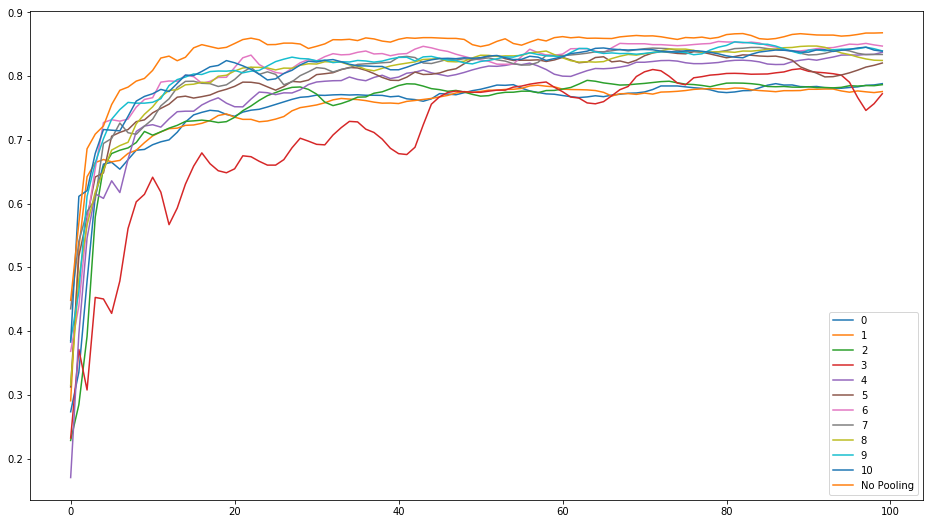

In [11]:


plt.figure(1, figsize = (16,9))
plt.clf()
for i,accura in enumerate(Pool_Valid_Acc.T):
    plt.plot(accura , label = i)
    
plt.plot(Valid_Acc , label = "No Pooling")



plt.legend()

In [10]:
print(Pool_Valid_Acc1.T[-1,-1])
print(Pool_Valid_Acc.T[-1,-1])

0.868
0.8392


In [9]:
x_pool_All

array([0.])